# Projekt NLP
Autor: Wojciech Sitek

### A. Temat projektu
1. zweryfikowanie prawa Zipfa - ranga * częstotliwość = const
2. występowanie słów składowych deskryptora opisującego artykuł w jego abstrakcie dla różnych deskryptorów
3. badanie względnego współwystępowania bigramów z wygładzaniem Laplace’a, Add-k oraz UnigramPrior
### B. Zbiór danych
Przetwarzanym zbiorem danych jest zbiór publikacji medycznych PubMed, pobrany w formacie JSON z konkursu BioAsq.

### 0. Wstępne przetwarzanie danych
Na początku przygotowano wstępne przetwarzanie danych. Przez klasę Preprocessor przetworzono wszystkie abstrakty artykułów naukowych - tam przeprowadzono tokenizację, usunięcie *stop words* oraz stemming, a następnie skategoryzowano w słowniku do kolejnych liczb naturalnych. W celu przetwarzania do kolejnych zadań, utworzono:
- dla prawa Zipfa, licznik słów (sama tokenizacja, bez usuwania słów przestankowych),
- dla występowania słów składowych deskryptora, licznik wystąpień nazw deskryptorów w oznaczonych przez nie abstraktach,
- dla badania współwystępowania bigramów, stworzono mapę częstości występowania kolejnych bigramów.

In [9]:
import os
from typing import List, Optional, Dict, Tuple
from tqdm import tqdm
import json
from collections import Counter
import gensim
from indexingcode.utils.Preprocessor import Preprocessor
import nltk
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

preprocessor = Preprocessor(gensim.utils.tokenize, nltk.PorterStemmer())

def get_text(node):
    try:
        return node.text
    except AttributeError:
        return None


data_dir: str = '/media/wojtek/SanDisk/BioAsq'
file_extension: str = '.json'

files: List[str] = os.listdir(data_dir)
files: List[str] = list(filter(lambda x: file_extension in x, files))
records_json = []
records_csv = []

counter = Counter()
mhs_existance: Dict[str, Tuple[int, int]] = dict() # MH name -> (number of articles where exists, all articles number)
bigrams: Dict[int, Dict[int, int]] = dict() # {w(-1) -> {w(0) -> count}}

tok_preprocessor = Preprocessor(gensim.utils.tokenize, None)
NN = 50000

for filename in files:
    with open(os.path.join(data_dir, filename), encoding='ISO-8859-1') as f:
        articles: List[Dict] = json.load(f)['articles']
    for article in tqdm(articles[:NN]):
        text: str = article['abstractText']
        preprocessed_tokens: List[str] = preprocessor.preprocess_text(text)
        tokens: List[str] = tok_preprocessor.preprocess_text(text, only_tokenize=True)
        # 1. Zipf law
        counter.update(tokens)
        # 2. Descriptors
        for mh in article['meshMajor']:
            if mh not in mhs_existance:
                mhs_existance[mh] = (0, 0)
            mh_tokens = preprocessor.preprocess_text(mh)
            is_existing: bool = all(map(lambda mh_token: mh_token in preprocessed_tokens, mh_tokens))
            existing_int: int = 1 if is_existing else 0
            mhs_existance[mh] = (mhs_existance[mh][0] + existing_int, mhs_existance[mh][1] + 1)
        # 3. Bigrams
        for a, b in nltk.bigrams(tokens):
            if a not in bigrams:
                bigrams[a] = dict()
            if b not in bigrams[a]:
                bigrams[a][b] = 0
            bigrams[a][b] += 1

[nltk_data] Downloading package stopwords to /home/wojtek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/wojtek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 50000/50000 [02:30<00:00, 332.08it/s]


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

### 1. Prawo Zipfa

Prawo Zipfa dotyczy specyficznej zależności odnośnie częstotliwości występowania poszczególnych słów w korpusach tekstowych, mianowicie ranga słowa, czyli jego numer porządkowy, jest odwrotnie proporcjonalna do częstotliwości jego występowania. Próbowano zweryfikować prawo Zipfa

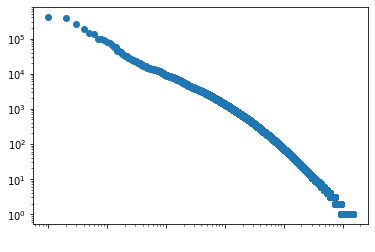

In [16]:
c = dict(counter.most_common())
plt.scatter(x=list(map(str, c.keys())), y=c.values())
plt.yscale('log')
plt.xscale('log')
plt.xticks(color='w')
plt.show()
None

Okazało się, że dla abstraktów artykułów biomedycznych idealnie spełnione jest Prawo Zipfa.

### 2. Występowanie słów składowych deskryptora w opisanym przez niego abstrakcie

In [36]:
existance_probs = list(map(lambda v: v[0]/v[1], mhs_existance.values()))
existance_list = list(mhs_existance.values())
existance_probs_with_n = list(map(lambda v: (v[0]/v[1], v[1]), mhs_existance.values()))

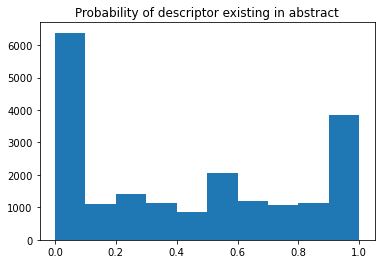

In [37]:
plt.hist(existance_probs)
plt.title('Probability of descriptor existing in abstract')
None

Zbadano prawdopodobieństwo występowania deskryptora w abstrakcie dla różnych deskryptorów. Okazało się, że najwięcej deskryptorów znajduje się w klasach brzegowych - albo w pełni występują w abstraktach, albo w ogóle nie występują.

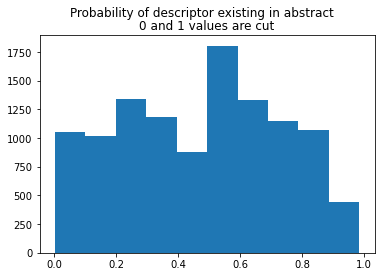

In [38]:
existance_probs_without_01 = list(filter(lambda x: 0.0 < x < 1.0, existance_probs))
plt.hist(existance_probs_without_01)
plt.suptitle('Probability of descriptor existing in abstract')
plt.title('0 and 1 values are cut')
None

Okazało się, że rozkład p-stwa występowania deskryptorów w abstrakcie przypomina rozkład normalny ze środkiem w punkcie 0.5, co obrazuje także poniższy wykres pudełkowy.

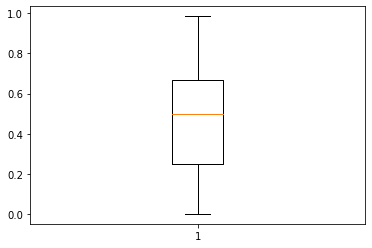

In [39]:
plt.boxplot(existance_probs_without_01)
None

In [40]:
def compute_by_total(bin_count = 1):
    ex_by_total: Dict[int, List[int]] = dict()
    for k, n in existance_probs_with_n:
        bin = int(n / bin_count)
        if bin not in ex_by_total:
            ex_by_total[bin] = []
        ex_by_total[bin].append(k)
    return list(map(lambda x: np.mean(x[1]), sorted(ex_by_total.items())))

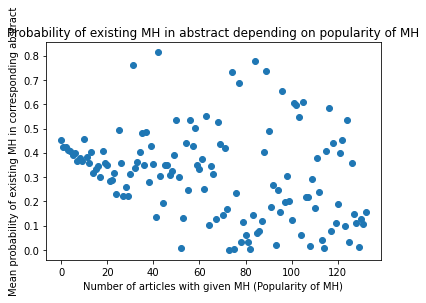

In [41]:
cbt = compute_by_total(bin_count=10)
plt.scatter(x=range(len(cbt)), y=cbt)
plt.title('Probability of existing MH in abstract depending on popularity of MH')
plt.xlabel('Number of articles with given MH (Popularity of MH)')
plt.ylabel('Mean probability of existing MH in corresponding abstract')
None

Następnie zbadano, czy w zależności od popularności deskryptora, różniła się jego obecność w tekście abstraktu. Okazało się, że trudno zaobserwować jakąś jednoznaczną zależność - dla podobnej dziedziny można zaobserwować bardzo różniące się wartości.

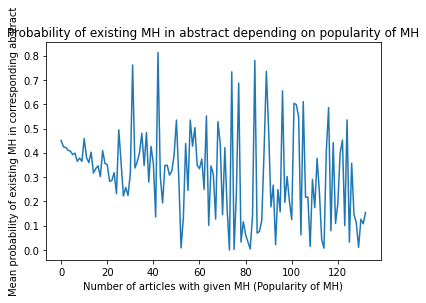

In [42]:
plt.plot(compute_by_total(bin_count=10))
plt.title('Probability of existing MH in abstract depending on popularity of MH')
plt.xlabel('Number of articles with given MH (Popularity of MH)')
plt.ylabel('Mean probability of existing MH in corresponding abstract')
None

Największe prawdopodobieństwo występowania deskryptora w odpowiadającym abstrakcie występuje dla deskryptorów średnio popularnych. Prawdopodobnie deksryptory występujące bardzo często są oczywiste i nie są umieszczane w tekście. Sprzeczne z oczekiwaniami jest niezbyt częste występowanie w publikacjach deskryptorów rzadkich.

### 3. Badanie względnego współwystępowania bigramów z wygładzaniem Laplace’a, Add-k oraz UnigramPrior

In [89]:
vocab_size = 30
bgs = np.zeros((vocab_size, vocab_size), dtype=int)
sums = np.zeros((vocab_size,), dtype=int)
popular_args = list(dict(counter.most_common(vocab_size)).keys())
for a, bdict in bigrams.items():
    for b, count in bdict.items():
        if a in popular_args and b in popular_args:
            i = popular_args.index(a)
            j = popular_args.index(b)
        else:
            continue
        bgs[i,j] = count
        sums[i] += count

In [91]:
num_to_text = {v: k for k, v in tok_preprocessor.vocabulary.items()}

In [93]:
labels = [num_to_text[i] for i in popular_args]

In [94]:
simple_bigrams = pd.DataFrame(bgs, index=labels, columns=labels)

In [95]:
norm_simple_bigrams = simple_bigrams.apply(lambda x: x/np.sum(x), axis=1)

In [96]:
laplace_bigrams = simple_bigrams.apply(lambda x: x+1, axis=1)

In [97]:
norm_laplace_bigrams = laplace_bigrams.apply(lambda x: x/np.sum(x), axis=1)

In [103]:
k = 100
add_k_bigrams = simple_bigrams.apply(lambda x: x+k, axis=1)

In [104]:
norm_add_k_bigrams = add_k_bigrams.apply(lambda x: x/np.sum(x), axis=1)

<AxesSubplot:>

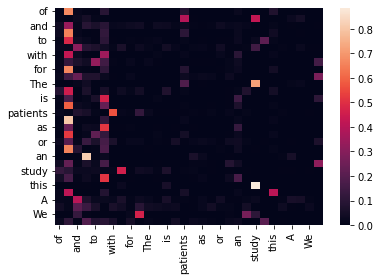

In [100]:
sns.heatmap(norm_simple_bigrams)

<AxesSubplot:>

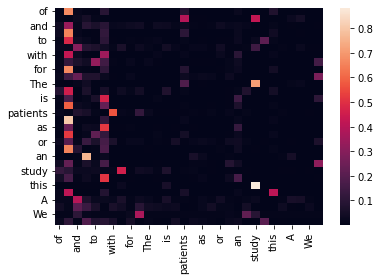

In [101]:
sns.heatmap(norm_laplace_bigrams)

<AxesSubplot:>

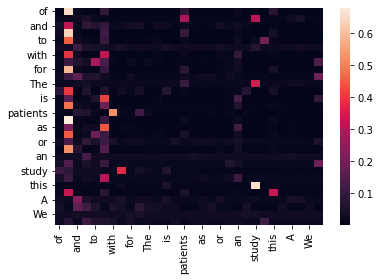

In [105]:
sns.heatmap(norm_add_k_bigrams)

Sporządzono trzy mapy ciepła dla ograniczonej przez parametr liczby najbardziej popularnych słów z korpusu. Znajdują się w nich niemalże tylko *stop words*. Przy wygładzaniu Laplace'a i plus K można ledwie zauważyć różnicę pojawienia się bardziej ciepłych kolorów w miejscach wcześniejszych zer. Można także zauważyć, że tylko niektóre słowa (of, and) współwystępują silniej w ramach bigramów, pozostałe z nich dużo mniej współwystępują między sobą. Ze względu na ograniczenia spostrzegania człowieka i ograniczenia przetwarzania komputera, trudno byłoby przeanalizować mapę ciepła wszystkich bigramów z korpusu. Z tego też powodu ograniczono się do 50000 abstraktów przy wykonywaniu projektu.